In [1]:
import os
import re
import numpy as np
import pandas as pd 

In [2]:
train_data = pd.read_csv("datas/train.csv")
train_data.head()
test_data = pd.read_csv("datas/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 각 Feature와 Survived의 상관관계 보기

In [4]:
train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [5]:
# 형제자매수와 생존률의 상관관계
train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [6]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# 데이터 전처리

In [7]:
data = pd.concat((train_data.loc[:, 'Pclass':'Embarked'], test_data.loc[:, 'Pclass':'Embarked']))
data = data.reset_index(drop=True)

In [8]:
# 이름 feature 없애기
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [9]:
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].replace('Ms', 'Miss')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data.drop(['Name'], axis=1, inplace=True)

In [10]:
data.drop(['Ticket'], axis=1, inplace=True)

In [11]:
sex_mapping = {"female": 0, "male": 1}
data['Sex'] = data['Sex'].map(sex_mapping)

In [12]:
data['Age'].fillna(data['Age'].median(), inplace=True)

In [13]:
data['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [14]:
def fare_category(fr): 
    if fr <= 7.90:
        return 1
    elif fr <= 14.454 and fr > 7.90:
        return 2
    elif fr <= 31.28 and fr > 14.454:
        return 3
    return 4

data['Fare_cat'] = data['Fare'].apply(fare_category)

In [15]:
data['Cabin'] = data['Cabin'].fillna('U')
data['Cabin'] = data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
data['Cabin'] = data['Cabin'].map(cabin_category)

In [16]:
data["Embarked"] = data["Embarked"].fillna("S")
cabin_category = {'S':1, 'C':2, 'Q':3}
data["Embarked"] = data["Embarked"].map(cabin_category).astype(int)

# 새로운 Feature 추가

In [17]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['SmallF'] = data['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
data['MedF']   = data['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
data['LargeF'] = data['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [18]:
data['Senior'] = data['Age'].map(lambda s:1 if s>70 else 0)
data['FareCat_Sex'] = data['Fare_cat']*data['Sex']
data['Pcl_Sex'] = data['Pclass']*data['Sex']
data['Pcl_Title'] = data['Pclass']*data['Title']
data['Title_Sex'] = data['Title']*data['Sex']

# 이게 Rich woman은 살 확률이 높고, Men 3Class는 죽을 확률이 높음?
data['Rich_woman'] = 0
data['Men_3Class'] = 0
data.loc[(data['Pclass']<=2) & (data['Sex']==0), 'Rich_woman'] = 1
data.loc[(data['Pclass']==3) & (data['Sex']==1), 'Men_3Class'] = 1
data['Rich_woman'] = data['Rich_woman'].astype(np.int8)
data['Alone'] = [1 if i == 1 else 0 for i in data['FamilySize']]

In [19]:
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Fare_cat,...,MedF,LargeF,Senior,FareCat_Sex,Pcl_Sex,Pcl_Title,Title_Sex,Rich_woman,Men_3Class,Alone
0,3,1,22.0,1,0,7.2500,1,1,1,1,...,0,0,0,1,3,3,1,0,1,0
1,1,0,38.0,1,0,71.2833,7,2,3,4,...,0,0,0,0,0,3,0,1,0,0
2,3,0,26.0,0,0,7.9250,1,1,2,2,...,0,0,0,0,0,6,0,0,0,1
3,1,0,35.0,1,0,53.1000,7,1,3,4,...,0,0,0,0,0,3,0,1,0,0
4,3,1,35.0,0,0,8.0500,1,1,1,2,...,0,0,0,2,3,3,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,28.0,0,0,8.0500,1,1,1,2,...,0,0,0,2,3,3,1,0,1,1
1305,1,0,39.0,0,0,108.9000,7,2,5,4,...,0,0,0,0,0,5,0,1,0,1
1306,3,1,38.5,0,0,7.2500,1,1,1,1,...,0,0,0,1,3,3,1,0,1,1
1307,3,1,28.0,0,0,8.0500,1,1,1,2,...,0,0,0,2,3,3,1,0,1,1


# Split Train Test set

In [20]:
#creating matrices for feature selection:
X_train = data[:train_data.shape[0]]
X_test = data[train_data.shape[0]:]
y = train_data.Survived
X_train['Survived'] = y

/var/folders/64/k822hl_10mj23sq9vlfc5lr80000gn/T/ipykernel_47251/1516246808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Survived'] = y


# Remove Constant Features

In [21]:
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0.00: 
        colsToRemove.append(col)
        
# remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True)
X_test.drop(colsToRemove, axis=1, inplace=True)
print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `0` Constant Columns

[]


/var/folders/64/k822hl_10mj23sq9vlfc5lr80000gn/T/ipykernel_47251/4237175042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(colsToRemove, axis=1, inplace=True)
/var/folders/64/k822hl_10mj23sq9vlfc5lr80000gn/T/ipykernel_47251/4237175042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(colsToRemove, axis=1, inplace=True)


In [22]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Sex,891.0,0.647587,0.477990,0.00,0.0000,1.0000,1.0,1.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Cabin,891.0,2.283951,2.460739,1.00,1.0000,1.0000,1.0,9.0000
Embarked,891.0,1.361392,0.635673,1.00,1.0000,1.0000,2.0,3.0000
Title,891.0,1.728395,1.030039,1.00,1.0000,1.0000,2.0,5.0000
Fare_cat,891.0,2.497194,1.111100,1.00,1.5000,3.0000,3.0,4.0000


# Outlier Detection

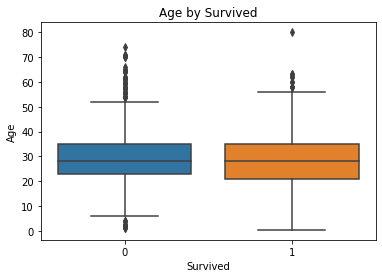

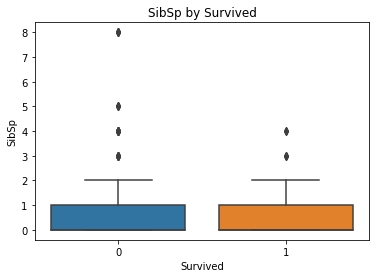

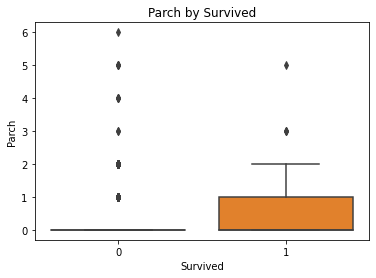

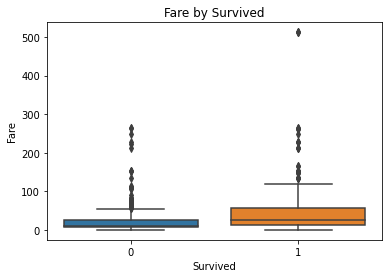

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

features = X_train[['Age', 'SibSp', 'Parch', 'Fare']].columns
for i in features:
    sns.boxplot(x="Survived", y=i, data=X_train)
    plt.title(i+" by "+"Survived")
    plt.show()

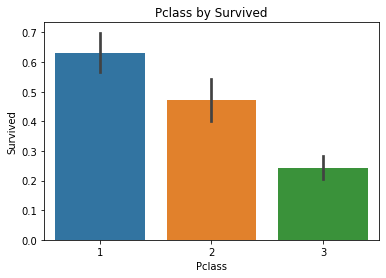

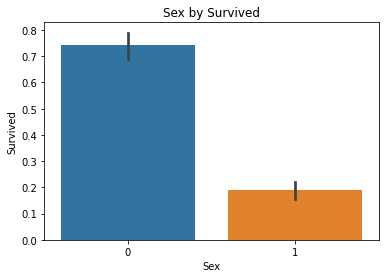

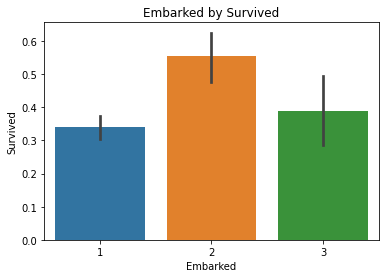

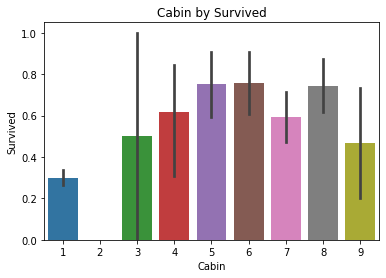

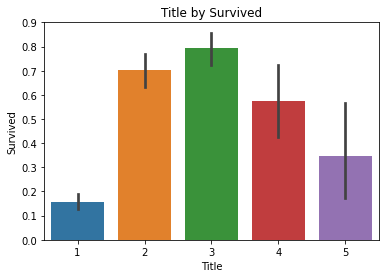

In [24]:
cat_features = X_train[['Pclass', 'Sex', 'Embarked', 'Cabin', 'Title']].columns
for i in cat_features:
    sns.barplot(y="Survived",x=i,data=X_train)
    plt.title(i+" by "+"Survived")
    plt.show()

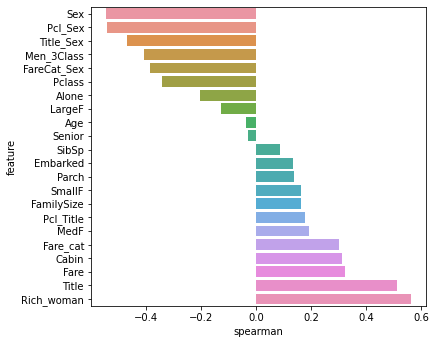

In [25]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = X_train.drop(['Survived'], axis=1).columns
spearman(X_train, features)

# 학습하기

In [26]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X = X_train.drop('Survived', axis=1)
y = X_train.Survived

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# y Class가 균등 분포가 되도록 sampling
ros = RandomOverSampler(random_state=42)
x_train, y_train= ros.fit_resample(x_train, y_train)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test)

In [27]:
params = {
        'objective':'binary:hinge',
        'max_depth':8, # first pair to tune from 0 to 13
        'learning_rate':0.1, # 4th to tune
        'eval_metric':'auc',
        'min_child_weight':12, # first pair to tune from 0 to 12
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':42,
        #'reg_lambda':1,
        'reg_alpha':0, # 3rd to tune 
        'gamma':0.9, # second for tune with step 0.1 from 0 to 0.5
        'scale_pos_weight':1,
        'n_estimators': 5000,
        'nthread':-1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=50, 
                           maximize=True, verbose_eval=10)
from sklearn import metrics

y_pred = model.predict(d_valid)
y_pred = [1 if y>0.5 else 0 for y in y_pred]
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid, y_pred)))

[0]	train-auc:0.50000	valid-auc:0.50000
[10]	train-auc:0.80606	valid-auc:0.76852
[20]	train-auc:0.85051	valid-auc:0.83796
[30]	train-auc:0.86768	valid-auc:0.85648
[40]	train-auc:0.88384	valid-auc:0.85648
[50]	train-auc:0.88081	valid-auc:0.86574
[60]	train-auc:0.88586	valid-auc:0.86574
[70]	train-auc:0.89192	valid-auc:0.85185
[80]	train-auc:0.89394	valid-auc:0.86574
[90]	train-auc:0.89596	valid-auc:0.87500
[100]	train-auc:0.89798	valid-auc:0.87500
[110]	train-auc:0.90404	valid-auc:0.87500
[120]	train-auc:0.90909	valid-auc:0.87500
[130]	train-auc:0.91010	valid-auc:0.87500
[136]	train-auc:0.91313	valid-auc:0.87500
Accuracy :0.86667
AUC : 0.87500
Precision : 0.78571
Recall : 0.91667
F1 : 0.84615


/opt/homebrew/Caskroom/miniforge/base/envs/research/lib/python3.9/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/research/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:28:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


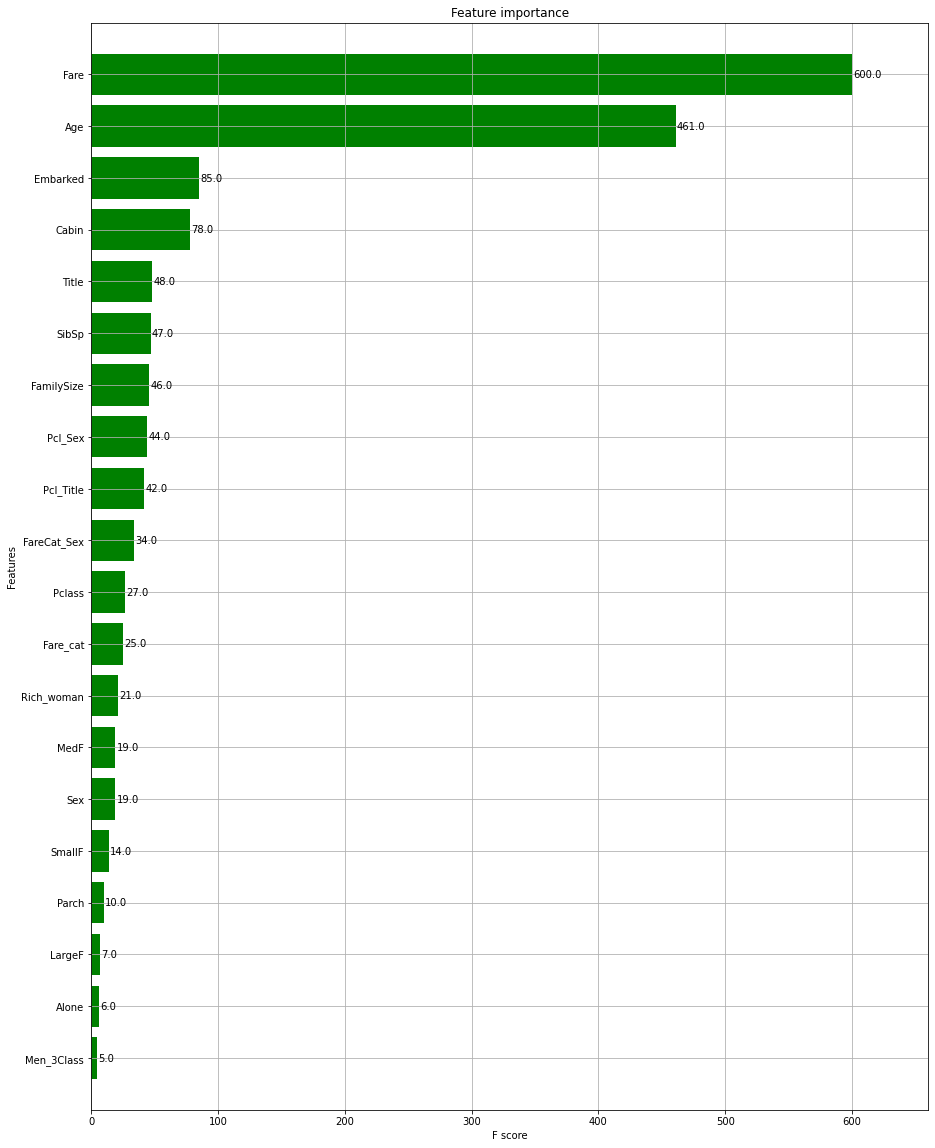

In [28]:
fig,ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model,ax=ax,max_num_features=20,height=0.8,color='g')
plt.show()

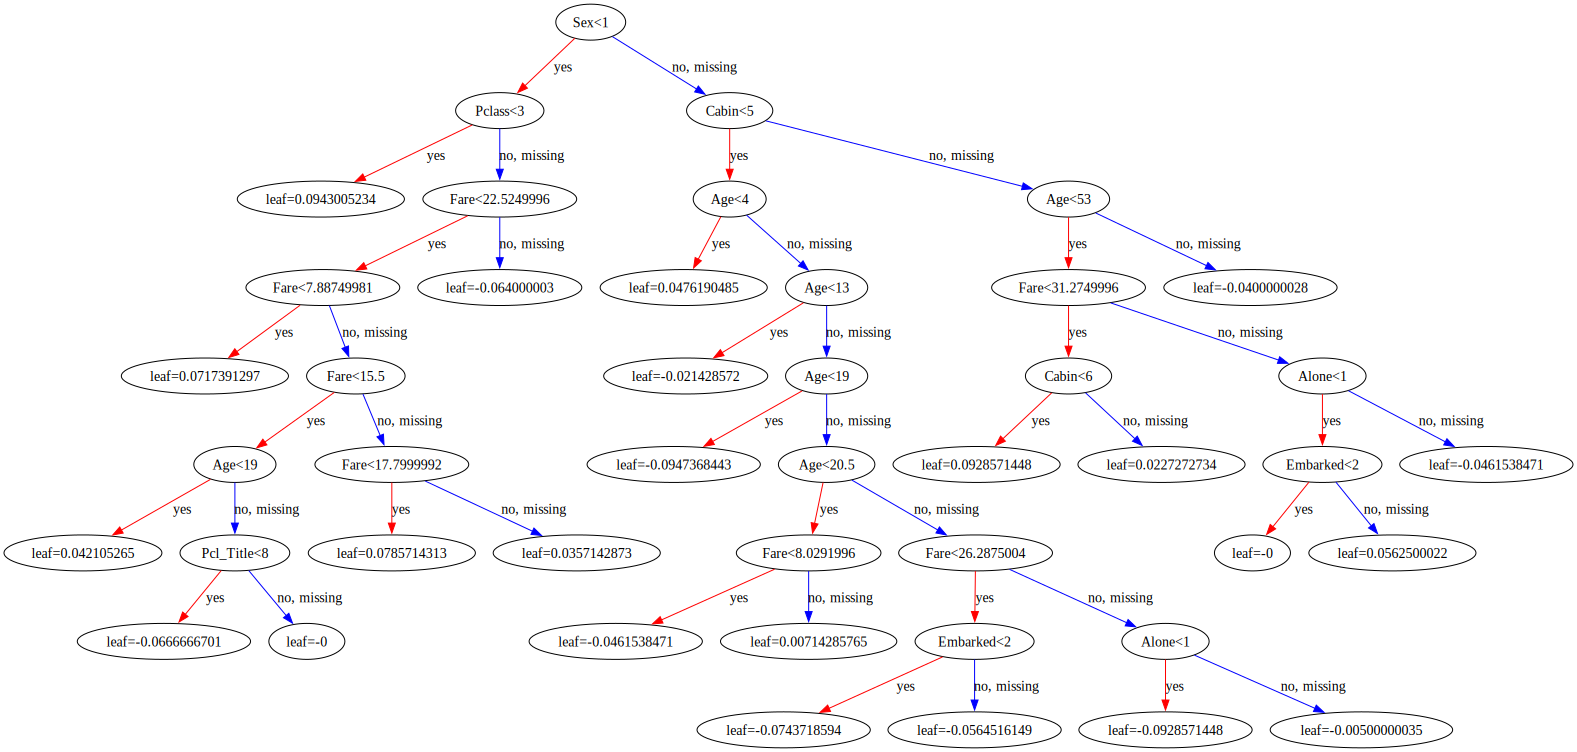

In [29]:
xgb.to_graphviz(model)

In [30]:
final_prediction = model.predict(d_test)
save = pd.DataFrame({"PassengerId": test_data['PassengerId'],
                   "Survived": final_prediction.astype(int)})
save.to_csv("submission.csv", index=False)